In [1]:
!pip install pandas torch transformers datasets openai openxlab

INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
  Using cached openxlab-0.1.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.38-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.37-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.36-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.35-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.34-py3-none-any.whl.metadata (3.8 kB)
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
  Using cached openxlab-0.0.33-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.32-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.31-py3-none-any.whl.metadata (3.8 kB)
  Using cached openxlab-0.0.30-py3-none-any.wh

In [2]:
from datasets import load_dataset
import json
import os
import base64
from openai import OpenAI
import pandas as pd

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_files = {
'train': 'https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/train.csv',
'test': 'https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/test.csv',
# If you want to include 'test_clean.csv', you can add it as well
# 'test_clean': 'https://huggingface.co/datasets/xmcmic/PMC-VQA/resolve/main/test_clean.csv',
}

dataset = load_dataset('csv', data_files=data_files)

In [5]:
file_path="/teamspace/studios/this_studio/llm-healthcare/robustness_experments/metadata/PMC-OA/inputfiles/pmcoa_factuality.jsonl"
q_list = set()
m_cnt = 0
a_cnt =0
with open(file_path, "r") as file:
    for line in file:
        record = json.loads(line)
        img_name = record.get("image_id")
        img_path= "/teamspace/studios/this_studio/figures" + os.path.sep + img_name
        if os.path.exists(img_path):
            #print(f"{img_path} exists")
            a_cnt += 1
            q_list.add(record.get("question_id"))
        else:
            #print(f"{img_path} does not exists")
            m_cnt += 1
print(f"{m_cnt} file out of {m_cnt + a_cnt} does not exist that means we have {a_cnt} files")

        

12302 file out of 13294 does not exist that means we have 992 files


In [ ]:
/teamspace/studios/this_studio/figures

In [6]:
base_path = "/teamspace/studios/this_studio/figures"
df = pd.read_json(file_path, lines=True)
def check_image_exists(image_id):
    img_path = os.path.join(base_path, image_id)
    return os.path.exists(img_path)
df["img_exists"] = df["image_id"].apply(check_image_exists)
df=df[df["img_exists"]==True]

In [9]:
from openai import OpenAI
def generate_response(prompt_text,image_link):
    client = OpenAI(api_key=open_ai_key)
    #image_link=base_path + os.path.sep + image_link
    def encode_image(image_path):
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    base64_image = encode_image(image_link)
    response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in this image?",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        }
    ],
)
    return response.choices[0]

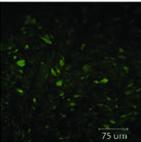

Original Text:
How many panels are there in the image, and what do they represent?

Ground Truth Answer:
normal labour, at term, and prolonged labour.

Model Response:
Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image appears to showcase a microscopic view of biological or organic material, with various bright green elements visible against a dark background. The scale indicates a size of 75 micrometers, suggesting it may be a detailed image of cells or other tiny structures.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))


Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image appears to showcase a microscopic view of biological or organic material, with various bright green elements visible against a dark background. The scale indicates a size of 75 micrometers, suggesting it may be a detailed image of cells or other tiny structures.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))

In [11]:
import os
import pandas as pd
from IPython.display import Image, display

def run_random_example(df, generate_response, base_image_path=""):
    random_row = df.sample(n=1).iloc[0]
    
    # Extract values from the row
    image_id     = random_row['image_id']
    ground_truth = random_row['answer']
    prompt_text  = random_row['text']
    image_info   = random_row['image']
    question_id  = random_row['question_id']
    img_exists   = random_row['img_exists']
    
    # Construct full image path if a base path is provided
    if base_image_path and not os.path.isabs(image_info):
        image_info = os.path.join(base_image_path, image_info)
    
    # Display the image if it exists; otherwise, print a message
    if img_exists and os.path.exists(image_info):
        display(Image(filename=image_info))
    else:
        print(f"Image with ID {image_id} does not exist at path: {image_info}")
    
    # Generate a response from the model using the prompt text and image information
    response = generate_response(prompt_text, image_info)
    
    # Print the original text prompt, ground truth answer, and the model's response
    print("Original Text:")
    print(prompt_text)
    print("\nGround Truth Answer:")
    print(ground_truth)
    print("\nModel Response:")
    print(response)
    
    return response

run_random_example(df, generate_response, base_image_path="/teamspace/studios/this_studio/figures")


In [51]:
for index, row in df.iterrows():
    image_id = row['image_id']
    ground_truth = row['answer']
    prompt_text = row['text']
    image_info = row['image']  
    question_id = row['question_id']
    img_exists = row['img_exists']
    response=generate_response(prompt_text,image_info)
    print(response)
    break;

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The image appears to show a microscopic view of biological tissue, likely stained to highlight specific cellular components. The colors suggest a fluorescence staining technique, where the blue may represent cell structures like nuclei, while the red indicates another component, possibly associated with a specific protein or cell type. This type of analysis is commonly used in biological and medical research to study tissue organization and cellular interactions.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))


In [13]:
client = OpenAI()

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


image_path = "path_to_your_image.jpg"

# Getting the Base64 string
base64_image = encode_image(image_path)

response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is in this image?",
                },
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        }
    ],
)

print(response.choices[0])

{26,
 27,
 28,
 29,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 120,
 121,
 122,
 123,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 342,
 343,
 344,
 345,
 369,
 370,
 371,
 372,
 373,
 374,
 393,
 394,
 395,
 396,
 397,
 398,
 443,
 444,
 445,
 446,
 447,
 448,
 449,
 454,
 455,
 456,
 457,
 458,
 459,
 521,
 522,
 523,
 524,
 525,
 526,
 527,
 556,
 557,
 558,
 656,
 657,
 658,
 659,
 660,
 661,
 694,
 695,
 696,
 697,
 773,
 774,
 775,
 776,
 777,
 778,
 859,
 860,
 861,
 862,
 881,
 882,
 883,
 884,
 885,
 886,
 1058,
 1059,
 1060,
 1061,
 1062,
 1078,
 1079,
 1080,
 1081,
 1176,
 1177,
 1366,
 1367,
 1368,
 1369,
 1370,
 1371,
 1372,
 1373,
 1374,
 1419,
 1420,
 1421,
 1422,
 1423,
 1424,
 1460,
 1461,
 1462,
 1463,
 1464,
 1465,
 1466,
 1516,
 1517,
 1518,
 1519,
 1520,
 1521,
 1545,
 1546,
 1547,
 1548,
 1563,
 1564,
 1565,
 1566,
 1567,
 1568,
 1590,
 1591,
 1592,
 1593,
 1594,
 1595,
 1596,
 1884,
 1885,
 1886,
 1887,
 1942,


In [14]:
openxlab.login()

AttributeError: module 'openxlab' has no attribute 'login'

In [ ]:
openxlab.

In [2]:
import openxlab
openxlab.login(ak="avq491mndmzyl6eed8be", sk="6anwxgemmk9lkydz4apvj7gdr3qgjpl5xe1vad0z") # Log in and enter the corresponding AK/SK. Please AK/SK at usercenter
from openxlab.dataset import get
get(dataset_repo='GMAI/OmniMedVQA', target_path='/teamspace/studios/this_studio/OmniMedVQA') # Dataset download


AttributeError: module 'openxlab' has no attribute 'login'